In [1]:
import pickle
import numpy as np
import lzma
import scipy.signal
import pickle
from scipy import signal
import matplotlib.pyplot as plt
import multiprocessing

vecbinsize = 0.25
def calSpectral(paramdict):
    vec_lst = VecbyParm_withGaussian_dic(paramdict)
    num_run = vec_lst.shape[0]
    num_cell = vec_lst.shape[1]
    result_freqlst = []
    for nrun in range(num_run):
        freq_byrun = []
        for ncell in range(num_cell):
            celldata = vec_lst[nrun][ncell]
            frequencies, psd = signal.welch(celldata, fs=1000/vecbinsize)
            cellfreq = {'freq': frequencies, 'psd': psd}
            freq_byrun.append(cellfreq)
        result_freqlst.append(freq_byrun)
    savefile_spectral(result_freqlst, paramdict)
    return 0

def add_gaussian_kernel(input_vector, kernel_size, sigma):

    # Define the Gaussian kernel
    kernel = scipy.signal.gaussian(kernel_size, sigma)
    
    # Initialize the result vector with zeros as floating-point numbers
    result_vector = np.zeros(len(input_vector), dtype=float)
    
    # Iterate through the input vector
    for i, value in enumerate(input_vector):
        if value == 1.0:
            # Add the Gaussian kernel to the result vector centered around the current index
            start_idx = max(0, i - (kernel_size // 2))
            end_idx = min(len(input_vector), i + (kernel_size // 2) + 1)
            result_vector[start_idx:end_idx] += kernel[
                (kernel_size // 2) - (i - start_idx) : (kernel_size // 2) + (end_idx - i)
            ]
    
    return result_vector

sigma_my = 1 / vecbinsize
kernel_size_my = int(sigma_my) * 5 * 2 + 1

def FiletoVec(name):
    with lzma.open("./savedoutput/" + name + ".xz", "rb") as fp:
        outsaved = pickle.load(fp)
    vec_space = vecbinsize
    spike_mat = np.zeros((len(outsaved), int(10000/vec_space)))
    for i in range(len(outsaved)):
        for n in range(len(outsaved[i])):
            j = int(outsaved[i][n]/vec_space)
            spike_mat[i, j] = 1
    return spike_mat

def FiletoVec_param(NetworkType, n, model_id, input_idx, MeanDelay, stdDelay, n_run):
    CellType = "point"
    name = str(NetworkType) + '_' + str(CellType) + '_layercount' + str(n) + '_model' + str(model_id) + '_input' + str(input_idx) + '_stddelay' + str(stdDelay) + '_meandelay' + str(MeanDelay) + '_nrun' + str(n_run)
    return FiletoVec(name)

def VecbyParm(NetworkType, n, model_id, input_idx, MeanDelay, stdDelay):
    vec_lst = []
    for n_run in np.arange(0, 10, 1):
        vec_lst.append(FiletoVec_param(NetworkType, n, model_id, input_idx, MeanDelay, stdDelay, n_run))
    return np.stack(vec_lst)

def VecbyParm_withGaussian(NetworkType, n, model_id, input_idx, MeanDelay, stdDelay):
    noguas = VecbyParm(NetworkType, n, model_id, input_idx, MeanDelay, stdDelay)
    result_3d = np.apply_along_axis(add_gaussian_kernel, axis=2, arr=noguas, kernel_size = kernel_size_my, sigma = sigma_my)
    return result_3d

def VecbyParm_withGaussian_dic(paramdict):
    NetworkType, n, model_id, input_idx, MeanDelay, stdDelay = paramdict['NetworkType'], paramdict['n'], paramdict['model_id'], paramdict['input_idx'], paramdict['MeanDelay'], paramdict['stdDelay']
    noguas = VecbyParm(NetworkType, n, model_id, input_idx, MeanDelay, stdDelay)
    result_3d = np.apply_along_axis(add_gaussian_kernel, axis=2, arr=noguas, kernel_size = kernel_size_my, sigma = sigma_my)
    return result_3d

def savefile_spectral(dataobj, paramdict):
    NetworkType, cellcount, model_id, input_idx, meandelay, stddelay = paramdict['NetworkType'], paramdict['n'], paramdict['model_id'], paramdict['input_idx'], paramdict['MeanDelay'], paramdict['stdDelay']
    with open('./SpectralProcessing/'+ NetworkType + "_cellcount" + str(cellcount) + "_meandelay" + str(meandelay) + "_stddelay" + str(stddelay) + "_modelid" + str(model_id) + "_inputid" + str(input_idx) + "_spectral.pkl",'wb') as f: 
        pickle.dump(dataobj, f)



    


paramlist = []
counter = 0
for networktype in ['FeedForward', 'ScaleFree', 'SmallWorld']:
    for cellcount in [200]:
        for modelid in range(10):
                for inputid in range(10):
                    for MeanDelay_noround in np.arange(3, 3.01, 0.2):
                        MeanDelay = np.round(MeanDelay_noround,1)
                        for stdDelay_noround in np.arange(0, 1.01, 0.05):
                            stdDelay = np.round(stdDelay_noround,2)
                            param = {'NetworkType': networktype, 'n': cellcount, 'model_id': modelid, 'input_idx': inputid, 'MeanDelay': MeanDelay, 'stdDelay': stdDelay, 'counter': counter}
                            paramlist.append(param)
                            counter += 1




In [2]:
len(paramlist)

6300

In [3]:
paramlist[1150]

{'NetworkType': 'FeedForward',
 'n': 200,
 'model_id': 5,
 'input_idx': 4,
 'MeanDelay': 3.0,
 'stdDelay': 0.8,
 'counter': 1150}

In [4]:
def VecbyParm_withGaussian_dic_varsigma(paramdict, sag):
    NetworkType, n, model_id, input_idx, MeanDelay, stdDelay = paramdict['NetworkType'], paramdict['n'], paramdict['model_id'], paramdict['input_idx'], paramdict['MeanDelay'], paramdict['stdDelay']
    noguas = VecbyParm(NetworkType, n, model_id, input_idx, MeanDelay, stdDelay)
    result_3d = np.apply_along_axis(add_gaussian_kernel, axis=2, arr=noguas, kernel_size = kernel_size_my, sigma = sag/0.25)
    return result_3d

In [25]:
vec_lst =VecbyParm_withGaussian_dic_varsigma(paramlist[1150], 1)
celldata = vec_lst[0][3]
len(celldata)

40000

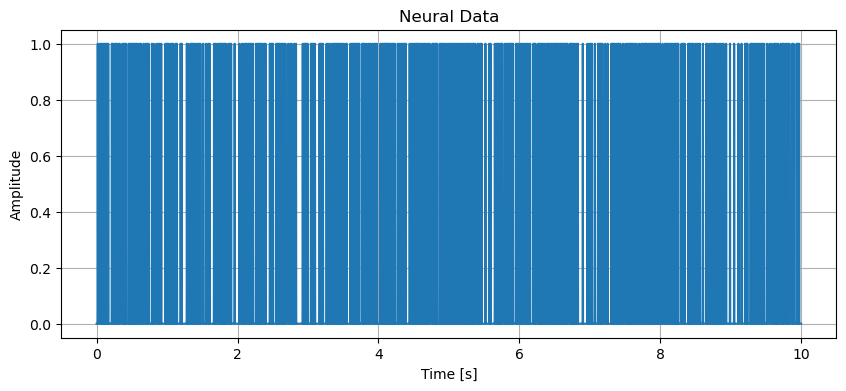

In [26]:
# Create time array
time_period = 10  # time period to plot
sampling_rate = 1000 / vecbinsize  # how many points to sample per second

t = np.linspace(0, time_period, int(sampling_rate * time_period), endpoint=False)

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(t, celldata)
plt.title('Neural Data')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

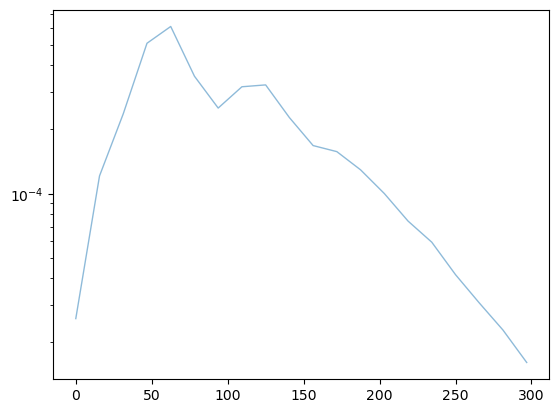

In [27]:
frequencies, psd = signal.welch(celldata, fs=sampling_rate)
cellfreq = {'freq': frequencies, 'psd': psd}
cellfreq

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.semilogy(
            cellfreq['freq'][:20],
            cellfreq['psd'][:20],
            linewidth=1, alpha=0.5
        )

In [28]:
signal.welch(celldata, fs=sampling_rate)

(array([   0.   ,   15.625,   31.25 ,   46.875,   62.5  ,   78.125,
          93.75 ,  109.375,  125.   ,  140.625,  156.25 ,  171.875,
         187.5  ,  203.125,  218.75 ,  234.375,  250.   ,  265.625,
         281.25 ,  296.875,  312.5  ,  328.125,  343.75 ,  359.375,
         375.   ,  390.625,  406.25 ,  421.875,  437.5  ,  453.125,
         468.75 ,  484.375,  500.   ,  515.625,  531.25 ,  546.875,
         562.5  ,  578.125,  593.75 ,  609.375,  625.   ,  640.625,
         656.25 ,  671.875,  687.5  ,  703.125,  718.75 ,  734.375,
         750.   ,  765.625,  781.25 ,  796.875,  812.5  ,  828.125,
         843.75 ,  859.375,  875.   ,  890.625,  906.25 ,  921.875,
         937.5  ,  953.125,  968.75 ,  984.375, 1000.   , 1015.625,
        1031.25 , 1046.875, 1062.5  , 1078.125, 1093.75 , 1109.375,
        1125.   , 1140.625, 1156.25 , 1171.875, 1187.5  , 1203.125,
        1218.75 , 1234.375, 1250.   , 1265.625, 1281.25 , 1296.875,
        1312.5  , 1328.125, 1343.75 , 1359.375, 

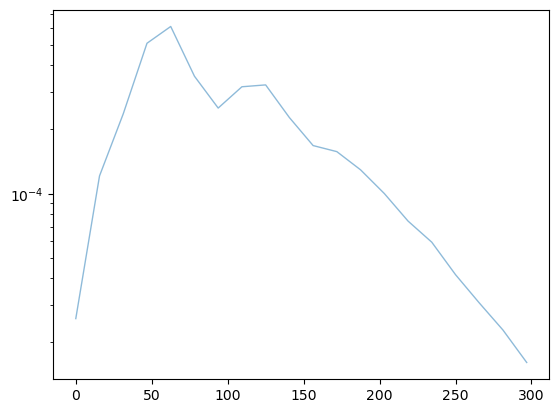

In [8]:
frequencies, psd = signal.welch(celldata, fs=sampling_rate)
cellfreq = {'freq': frequencies, 'psd': psd}
cellfreq

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.semilogy(
            cellfreq['freq'][:20],
            cellfreq['psd'][:20],
            linewidth=1, alpha=0.5
        )

In [9]:
# frequencies, psd = signal.welch(celldata, fs=sampling_rate)
# cellfreq = {'freq': frequencies, 'psd': psd}
# cellfreq

# import matplotlib.pyplot as plt
# fig, ax = plt.subplots()
# ax.semilogy(
#             cellfreq['freq'][:20],
#             cellfreq['psd'][:20],
#             linewidth=1, alpha=0.5
#         )

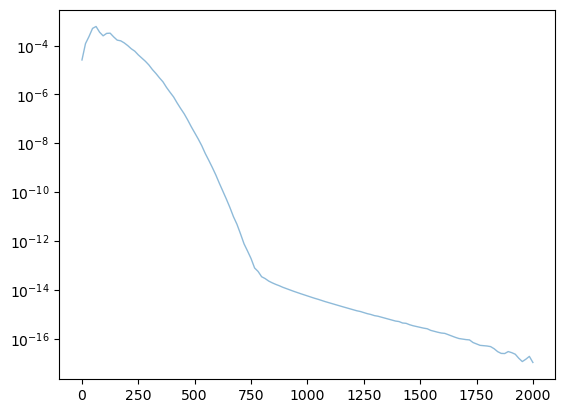

In [10]:
fig, ax = plt.subplots()
ax.semilogy(
            cellfreq['freq'][:2000],
            cellfreq['psd'][:2000],
            linewidth=1, alpha=0.5
        )

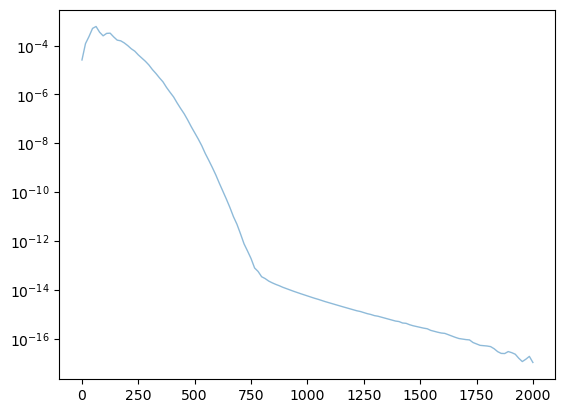

In [11]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.semilogy(
            cellfreq['freq'][:1000],
            cellfreq['psd'][:1000],
            linewidth=1, alpha=0.5
        )

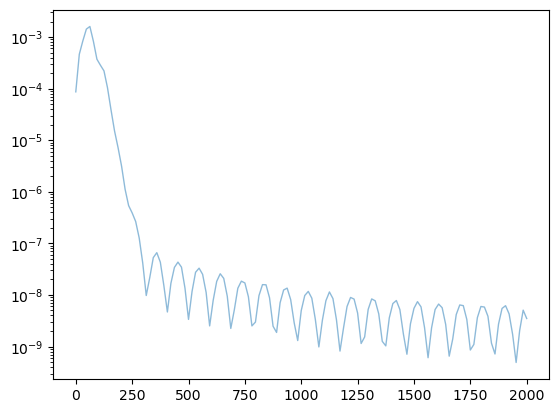

In [12]:
vec_lst =VecbyParm_withGaussian_dic_varsigma(paramlist[1], 2)
celldata = vec_lst[0][0]
frequencies, psd = signal.welch(celldata, fs=sampling_rate)
cellfreq = {'freq': frequencies, 'psd': psd}
fig, ax = plt.subplots()

ax.semilogy(
            cellfreq['freq'][:],
            cellfreq['psd'][:],
            linewidth=1, alpha=0.5
        )

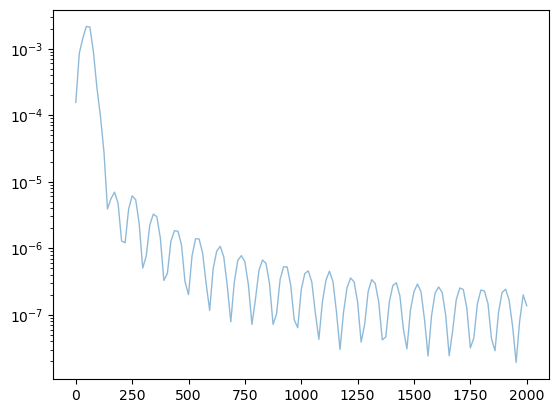

In [13]:
vec_lst =VecbyParm_withGaussian_dic_varsigma(paramlist[1], 3)
celldata = vec_lst[0][0]
frequencies, psd = signal.welch(celldata, fs=sampling_rate)
cellfreq = {'freq': frequencies, 'psd': psd}
fig, ax = plt.subplots()

ax.semilogy(
            cellfreq['freq'][:],
            cellfreq['psd'][:],
            linewidth=1, alpha=0.5
        )

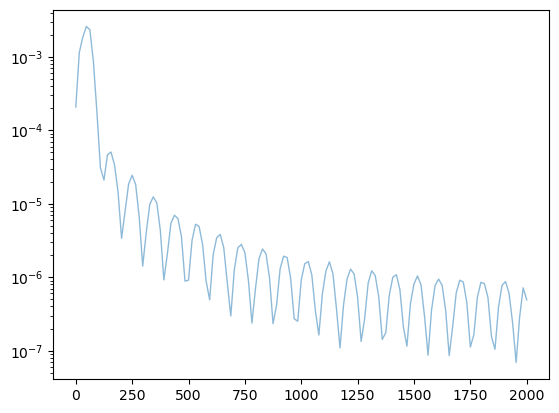

In [14]:
vec_lst =VecbyParm_withGaussian_dic_varsigma(paramlist[1], 4)
celldata = vec_lst[0][0]
frequencies, psd = signal.welch(celldata, fs=sampling_rate)
cellfreq = {'freq': frequencies, 'psd': psd}
fig, ax = plt.subplots()

ax.semilogy(
            cellfreq['freq'][:],
            cellfreq['psd'][:],
            linewidth=1, alpha=0.5
        )

In [15]:
sigma = 4
kernal = scipy.signal.exponential(10, tau = sigma,sym=False, )
kernal[:len(kernal)//2] = scipy.signal.exponential(10, tau = sigma/8,sym=False, )[:len(kernal)//2]

In [16]:
kernal

array([4.53999298e-05, 3.35462628e-04, 2.47875218e-03, 1.83156389e-02,
       1.35335283e-01, 1.00000000e+00, 7.78800783e-01, 6.06530660e-01,
       4.72366553e-01, 3.67879441e-01])

In [17]:
def add_Expo_kernel(input_vector, kernel_size, sigma):
    

    # Define the Exponenetial kernel 
    kernal = scipy.signal.exponential(kernel_size, tau = sigma,sym=False, )
    kernal[:len(kernal)//2] = scipy.signal.exponential(kernel_size, tau = sigma/8,sym=False, )[:len(kernal)//2]
    
    # Initialize the result vector with zeros as floating-point numbers
    result_vector = np.zeros(len(input_vector), dtype=float)
    
    # Iterate through the input vector
    for i, value in enumerate(input_vector):
        if value == 1.0:
            # Add the Gaussian kernel to the result vector centered around the current index
            start_idx = max(0, i - (kernel_size // 2))
            end_idx = min(len(input_vector), i + (kernel_size // 2) + 1)
            result_vector[start_idx:end_idx] += kernel[
                (kernel_size // 2) - (i - start_idx) : (kernel_size // 2) + (end_idx - i)
            ]
    
    return result_vector

def VecbyParm_withExpo(NetworkType, n, model_id, input_idx, MeanDelay, stdDelay):
    noguas = VecbyParm(NetworkType, n, model_id, input_idx, MeanDelay, stdDelay)
    result_3d = np.apply_along_axis(add_Expo_kernel, axis=2, arr=noguas, kernel_size = kernel_size_my, sigma = sigma_my)
    return result_3d

def VecbyParm_withExpo_dic(paramdict, ):
    NetworkType, n, model_id, input_idx, MeanDelay, stdDelay = paramdict['NetworkType'], paramdict['n'], paramdict['model_id'], paramdict['input_idx'], paramdict['MeanDelay'], paramdict['stdDelay']
    noguas = VecbyParm(NetworkType, n, model_id, input_idx, MeanDelay, stdDelay)
    result_3d = np.apply_along_axis(add_Expo_kernel, axis=2, arr=noguas, kernel_size = kernel_size_my, sigma = sigma_my)
    return result_3d

def VecbyParm_withExpo_dic_varsigma(paramdict, sag):
    NetworkType, n, model_id, input_idx, MeanDelay, stdDelay = paramdict['NetworkType'], paramdict['n'], paramdict['model_id'], paramdict['input_idx'], paramdict['MeanDelay'], paramdict['stdDelay']
    noguas = VecbyParm(NetworkType, n, model_id, input_idx, MeanDelay, stdDelay)
    result_3d = np.apply_along_axis(add_gaussian_kernel, axis=2, arr=noguas, kernel_size = kernel_size_my, sigma = sag/0.25)
    return result_3d

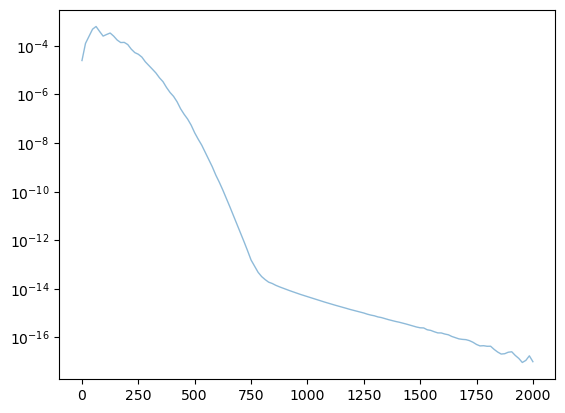

In [18]:
vec_lst =VecbyParm_withExpo_dic_varsigma(paramlist[1], 1)
celldata = vec_lst[0][0]
frequencies, psd = signal.welch(celldata, fs=sampling_rate)
cellfreq = {'freq': frequencies, 'psd': psd}
fig, ax = plt.subplots()

ax.semilogy(
            cellfreq['freq'][:],
            cellfreq['psd'][:],
            linewidth=1, alpha=0.5
        )

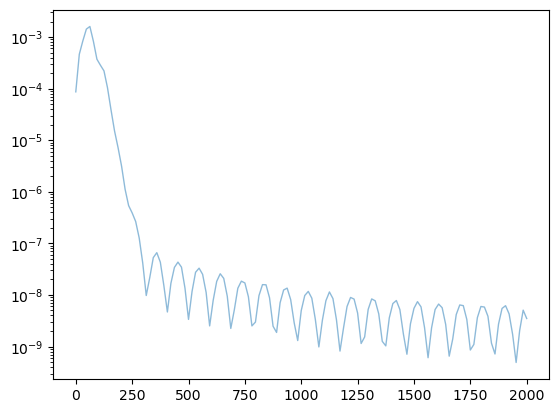

In [19]:
vec_lst =VecbyParm_withExpo_dic_varsigma(paramlist[1], 2)
celldata = vec_lst[0][0]
frequencies, psd = signal.welch(celldata, fs=sampling_rate)
cellfreq = {'freq': frequencies, 'psd': psd}
fig, ax = plt.subplots()

ax.semilogy(
            cellfreq['freq'][:],
            cellfreq['psd'][:],
            linewidth=1, alpha=0.5
        )

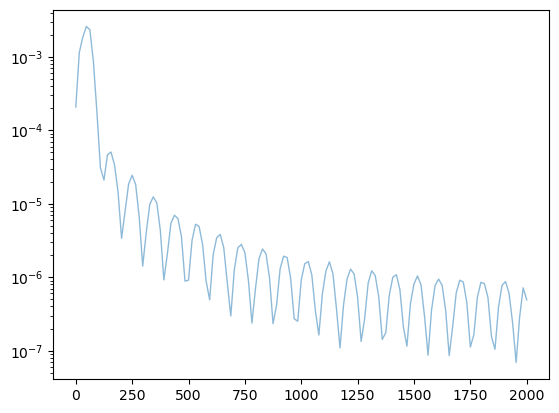

In [20]:
vec_lst =VecbyParm_withExpo_dic_varsigma(paramlist[1], 4)
celldata = vec_lst[0][0]
frequencies, psd = signal.welch(celldata, fs=sampling_rate)
cellfreq = {'freq': frequencies, 'psd': psd}
fig, ax = plt.subplots()

ax.semilogy(
            cellfreq['freq'][:],
            cellfreq['psd'][:],
            linewidth=1, alpha=0.5
        )

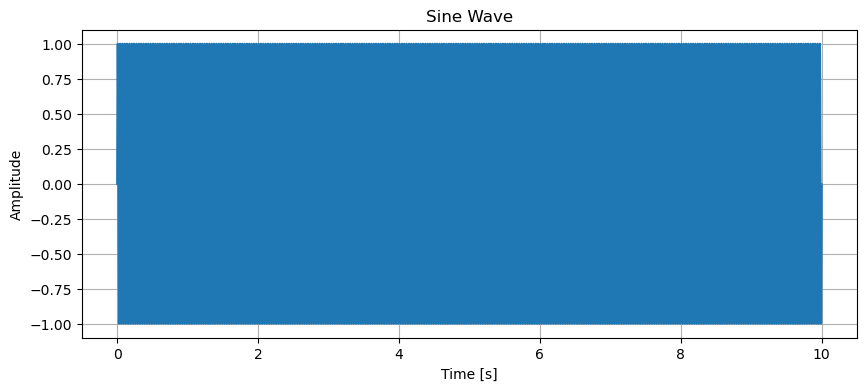

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
frequency = 30  # frequency of the sine wave
amplitude = 1    # amplitude of the sine wave
time_period = 10  # time period to plot
sampling_rate = 1000 / 0.025  # how many points to sample per second

# Create time array
t = np.linspace(0, time_period, int(sampling_rate * time_period), endpoint=False)

# Generate sine wave
y = amplitude * np.sin(2 * np.pi * frequency * t)

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(t, y)
plt.title('Sine Wave')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


In [22]:
len(y)

400000

In [23]:
frequencies, psd = signal.periodogram(y, fs=sampling_rate)
cellfreq = {'freq': frequencies, 'psd': psd}
cellfreq

{'freq': array([0.00000e+00, 1.00000e-01, 2.00000e-01, ..., 1.99998e+04,
        1.99999e+04, 2.00000e+04]),
 'psd': array([8.35102676e-34, 8.22461786e-34, 2.65674456e-33, ...,
        1.24081873e-33, 1.62823874e-33, 7.53344277e-33])}

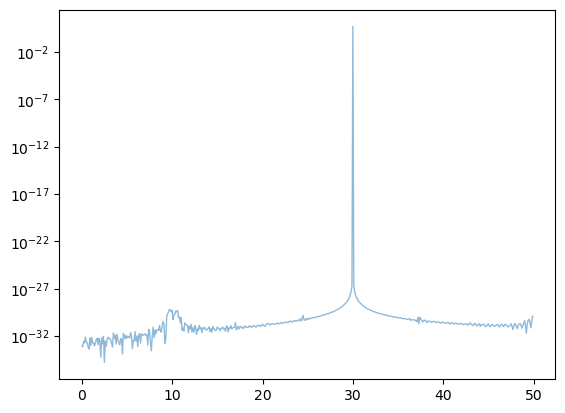

In [24]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.semilogy(
            cellfreq['freq'][:500],
            cellfreq['psd'][:500],
            linewidth=1, alpha=0.5
        )